In [2]:
import pickle
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from urllib.request import urlopen
import cloudpickle as cp


In [2]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

In [3]:
# load data
us_cases = pickle.load( open( "../data/us_state_cases_deaths.p", "rb" ) )
us_cases.head()

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24


In [4]:
# get new york - fetch only case data
ny = us_cases.loc[us_cases["abbrev"] == "NY"]
ny["date"] = pd.to_datetime(ny["date"])
ny["new_cases"] = ny["cases"].diff()

# uni-fy
uni_ny = ny["new_cases"][2:]
uni_ny.index = ny["date"][2:]
uni_ny = uni_ny.values

uni_ny
# tf.keras.utils.normalize(uni_ny, axis=-1)

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 9.0000e+00, 1.1000e+01, 2.2000e+01, 4.5000e+01,
       1.7000e+01, 3.6000e+01, 3.1000e+01, 4.4000e+01, 1.0900e+02,
       9.5000e+01, 1.8900e+02, 1.2200e+02, 2.1800e+02, 4.2500e+02,
       1.0120e+03, 1.7740e+03, 2.9520e+03, 3.2580e+03, 4.8170e+03,
       5.7110e+03, 4.8040e+03, 7.4130e+03, 5.9410e+03, 5.6880e+03,
       8.7710e+03, 6.2670e+03, 7.6790e+03, 8.7490e+03, 8.1520e+03,
       8.6080e+03, 1.0680e+04, 1.2312e+04, 8.1220e+03, 7.9760e

In [5]:
# standardize
TRAIN_SPLIT = 80
uni_train_mean = uni_ny[:TRAIN_SPLIT].mean()
uni_train_std = uni_ny[:TRAIN_SPLIT].std()

uni_ny = (uni_ny-uni_train_mean)/uni_train_std


In [6]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_ny, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_ny, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
  
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

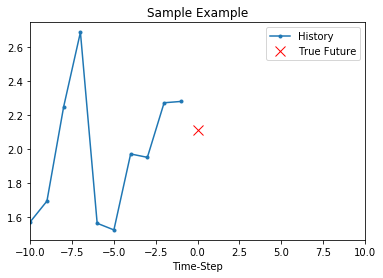

In [8]:
show_plot([x_train_uni[69], y_train_uni[69]], 0, 'Sample Example')


<module 'matplotlib.pyplot' from '/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

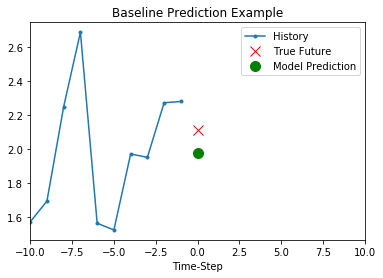

In [9]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[69], y_train_uni[69], baseline(x_train_uni[69])], 0,
           'Baseline Prediction Example')

RNN


In [10]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [18]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [19]:
simple_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = simple_lstm_model.fit(
    x_train_uni, y_train_uni,
    epochs=30,
    batch_size=16,
    validation_data=(x_val_uni, y_val_uni),
    verbose=1,
    shuffle=False
)

Train on 70 samples, validate on 17 samples
Epoch 1/30


In [13]:
# EVALUATION_INTERVAL = 10
# EPOCHS = 10

# simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
#                       steps_per_epoch=EVALUATION_INTERVAL,
#                       validation_data=val_univariate,
#                       validation_steps=10)
